# Fraud Detection in Financial Transactions
**Accredian Data Science & Machine Learning Internship Task**

Building a predictive model for proactive fraud detection on a dataset of 6.3M financial transactions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                              roc_curve, precision_recall_curve, average_precision_score,
                              f1_score, accuracy_score, precision_score, recall_score)
from sklearn.feature_selection import mutual_info_classif

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print('Libraries loaded successfully.')

Libraries loaded successfully.


---
## Q1. Data Cleaning: Missing Values, Outliers, and Multicollinearity

In [2]:
# Load data
df = pd.read_csv('Fraud.csv')
print(f'Dataset shape: {df.shape}')
print(f'\nColumn types:\n{df.dtypes}')
df.head()

Dataset shape: (6362620, 11)

Column types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
# === MISSING VALUES ===
print('=== Missing Values ===')
missing = df.isnull().sum()
print(missing)
print(f'\nTotal missing: {missing.sum()} -> No missing values in the dataset.')

=== Missing Values ===


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Total missing: 0 -> No missing values in the dataset.


In [4]:
# === DUPLICATES ===
print(f'Duplicate rows: {df.duplicated().sum()}')

Duplicate rows: 0


In [5]:
# === BASIC STATISTICS ===
print('=== Numeric Summary ===')
df.describe().round(2)

=== Numeric Summary ===


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6.362620e+06,6.362620e+06,6362620.00,6362620.0
mean,243.40,179861.90,833883.10,855113.67,1.100702e+06,1.224996e+06,0.00,0.0
std,142.33,603858.23,2888242.67,2924048.50,3.399180e+06,3.674129e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,156.00,13389.57,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
50%,239.00,74871.94,14208.00,0.00,1.327057e+05,2.146614e+05,0.00,0.0
75%,335.00,208721.48,107315.18,144258.41,9.430367e+05,1.111909e+06,0.00,0.0
max,743.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


In [6]:
# === TARGET DISTRIBUTION ===
print('=== Fraud Distribution ===')
print(df['isFraud'].value_counts())
print(f'\nFraud rate: {df["isFraud"].mean()*100:.4f}%')
print(f'\nThis is a highly IMBALANCED dataset (only 0.13% fraud).')

print('\n=== isFlaggedFraud ===')
print(df['isFlaggedFraud'].value_counts())
print(f'isFlaggedFraud catches only {df["isFlaggedFraud"].sum()} of {df["isFraud"].sum()} frauds -> nearly useless.')

# Fraud by transaction type
print('\n=== Fraud by Transaction Type ===')
fraud_by_type = df.groupby('type').agg(
    total=('isFraud', 'count'),
    frauds=('isFraud', 'sum'),
    fraud_rate=('isFraud', 'mean')
).round(6)
print(fraud_by_type)
print('\n=> Fraud ONLY occurs in TRANSFER and CASH_OUT transactions.')

=== Fraud Distribution ===
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud rate: 0.1291%

This is a highly IMBALANCED dataset (only 0.13% fraud).

=== isFlaggedFraud ===
isFlaggedFraud
0    6362604
1         16
Name: count, dtype: int64
isFlaggedFraud catches only 16 of 8213 frauds -> nearly useless.

=== Fraud by Transaction Type ===


            total  frauds  fraud_rate
type                                 
CASH_IN   1399284       0    0.000000
CASH_OUT  2237500    4116    0.001840
DEBIT       41432       0    0.000000
PAYMENT   2151495       0    0.000000
TRANSFER   532909    4097    0.007688

=> Fraud ONLY occurs in TRANSFER and CASH_OUT transactions.


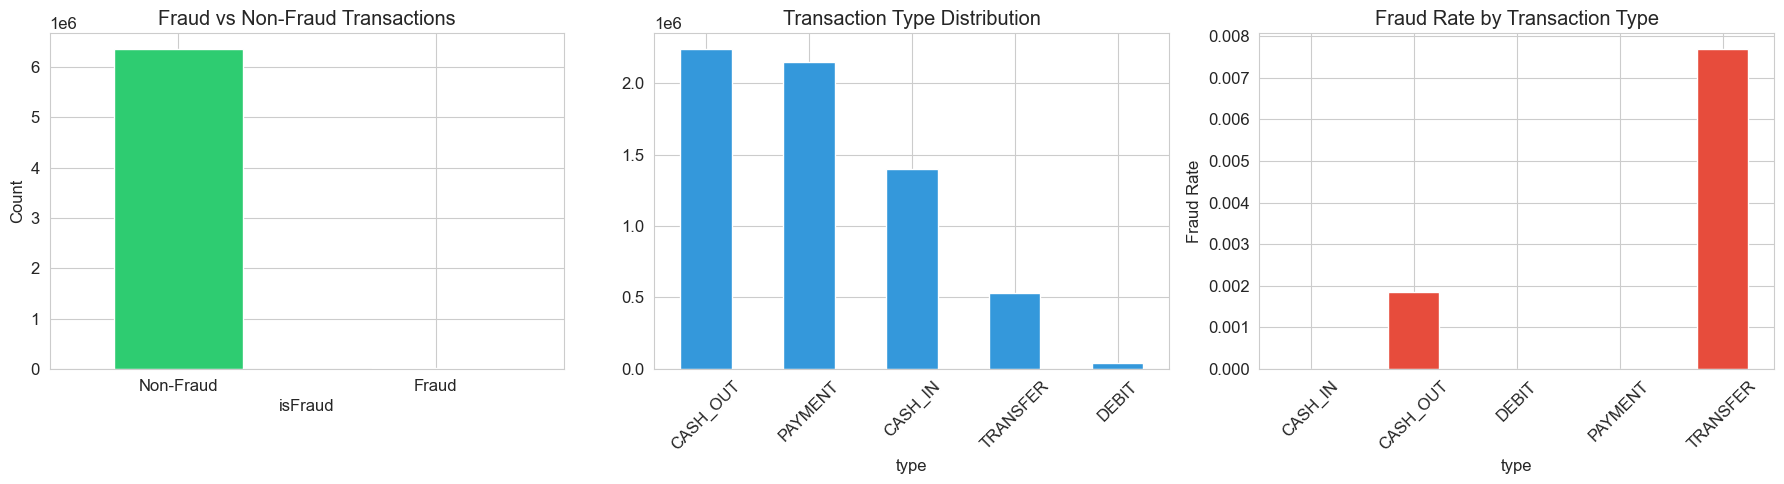

In [7]:
# Visualize fraud distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Fraud vs Non-fraud count
df['isFraud'].value_counts().plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c'])
axes[0].set_title('Fraud vs Non-Fraud Transactions')
axes[0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)
axes[0].set_ylabel('Count')

# Transaction type distribution
df['type'].value_counts().plot(kind='bar', ax=axes[1], color='#3498db')
axes[1].set_title('Transaction Type Distribution')
axes[1].tick_params(axis='x', rotation=45)

# Fraud rate by type
fraud_by_type['fraud_rate'].plot(kind='bar', ax=axes[2], color=['#2ecc71', '#e74c3c', '#2ecc71', '#2ecc71', '#e74c3c'])
axes[2].set_title('Fraud Rate by Transaction Type')
axes[2].set_ylabel('Fraud Rate')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('fig1_fraud_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# === OUTLIER ANALYSIS ===
# Using IQR method on amount
print('=== Outlier Analysis (Amount) ===')
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = df[(df['amount'] < lower) | (df['amount'] > upper)]
print(f'Q1: {Q1:,.2f}, Q3: {Q3:,.2f}, IQR: {IQR:,.2f}')
print(f'Lower bound: {lower:,.2f}, Upper bound: {upper:,.2f}')
print(f'Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)')
print(f'Fraud among outliers: {outliers["isFraud"].sum()} ({outliers["isFraud"].mean()*100:.2f}%)')
print(f'Fraud among non-outliers: {df.loc[~df.index.isin(outliers.index), "isFraud"].sum()}')
print('\n=> We will NOT remove outliers as fraudulent transactions are naturally high-value outliers.')
print('   Removing them would eliminate the very patterns we want to detect.')

=== Outlier Analysis (Amount) ===


Q1: 13,389.57, Q3: 208,721.48, IQR: 195,331.91
Lower bound: -279,608.29, Upper bound: 501,719.34
Outliers: 338078 (5.31%)
Fraud among outliers: 3854 (1.14%)
Fraud among non-outliers: 4359

=> We will NOT remove outliers as fraudulent transactions are naturally high-value outliers.
   Removing them would eliminate the very patterns we want to detect.


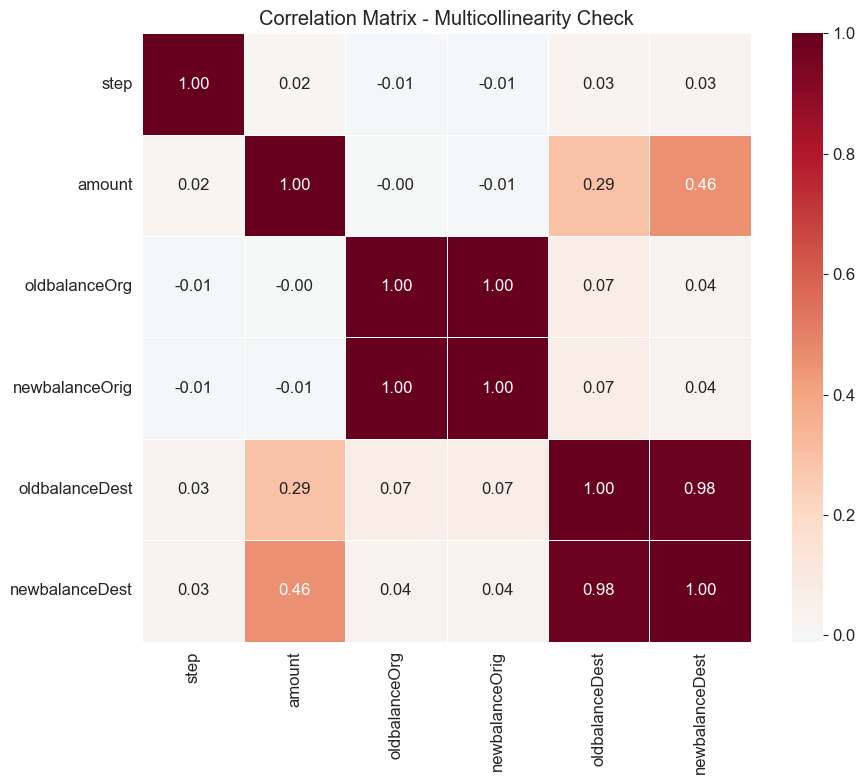


High correlations detected:
  oldbalanceOrg <-> newbalanceOrig: 0.999
  oldbalanceDest <-> newbalanceDest: 0.977

=> oldbalanceOrg & newbalanceOrig are highly correlated (expected: balance before/after).
   oldbalanceDest & newbalanceDest are highly correlated.
   We will engineer difference features instead of using raw balances.


In [9]:
# === MULTICOLLINEARITY CHECK ===
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax,
            square=True, linewidths=0.5)
ax.set_title('Correlation Matrix - Multicollinearity Check')
plt.tight_layout()
plt.savefig('fig2_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nHigh correlations detected:')
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        c = corr_matrix.iloc[i, j]
        if abs(c) > 0.5:
            print(f'  {numeric_cols[i]} <-> {numeric_cols[j]}: {c:.3f}')

print('\n=> oldbalanceOrg & newbalanceOrig are highly correlated (expected: balance before/after).')
print('   oldbalanceDest & newbalanceDest are highly correlated.')
print('   We will engineer difference features instead of using raw balances.')

---
## Q2 & Q3. Fraud Detection Model & Variable Selection

### Feature Engineering

**Variable Selection Rationale:**
1. **type**: Fraud only occurs in TRANSFER and CASH_OUT - critical discriminator
2. **amount**: Transaction amount - fraudsters often move large sums
3. **balance_diff_orig** (engineered): `oldbalanceOrg - newbalanceOrig` - captures if account was drained
4. **balance_diff_dest** (engineered): `newbalanceDest - oldbalanceDest` - captures if destination received funds
5. **orig_balance_error** (engineered): `newbalanceOrig + amount - oldbalanceOrg` - detects accounting anomalies
6. **dest_balance_error** (engineered): `oldbalanceDest + amount - newbalanceDest` - detects destination anomalies
7. **step** (hour): Time of transaction - fraud may cluster at certain hours

**Dropped variables:**
- `nameOrig`, `nameDest`: Categorical with millions of unique values - not useful for ML
- `isFlaggedFraud`: Only flags 16/8213 frauds - essentially useless
- Raw balances replaced by engineered difference features to handle multicollinearity

In [10]:
# === FEATURE ENGINEERING ===

# Since fraud ONLY occurs in TRANSFER and CASH_OUT, filter to these types
# This reduces data from 6.3M to 2.7M rows and focuses the model
df_model = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])].copy()
print(f'Filtered to TRANSFER & CASH_OUT: {len(df_model)} rows')
print(f'Fraud rate in filtered data: {df_model["isFraud"].mean()*100:.3f}%')

# Encode type: TRANSFER=1, CASH_OUT=0
df_model['type_encoded'] = (df_model['type'] == 'TRANSFER').astype(int)

# Engineer features
df_model['balance_diff_orig'] = df_model['oldbalanceOrg'] - df_model['newbalanceOrig']
df_model['balance_diff_dest'] = df_model['newbalanceDest'] - df_model['oldbalanceDest']
df_model['orig_balance_error'] = df_model['newbalanceOrig'] + df_model['amount'] - df_model['oldbalanceOrg']
df_model['dest_balance_error'] = df_model['oldbalanceDest'] + df_model['amount'] - df_model['newbalanceDest']

# Feature: is the origin account being drained (balance goes to 0)?
df_model['orig_drained'] = (df_model['newbalanceOrig'] == 0).astype(int)

# Feature: amount equals old balance (full account drain)
df_model['full_drain'] = (df_model['amount'] == df_model['oldbalanceOrg']).astype(int)

print(f'\nEngineered features created.')
print(f'Fraud where account is drained: {df_model[df_model["isFraud"]==1]["orig_drained"].mean()*100:.1f}%')
print(f'Non-fraud where account is drained: {df_model[df_model["isFraud"]==0]["orig_drained"].mean()*100:.1f}%')

Filtered to TRANSFER & CASH_OUT: 2770409 rows
Fraud rate in filtered data: 0.296%

Engineered features created.
Fraud where account is drained: 98.1%


Non-fraud where account is drained: 90.1%


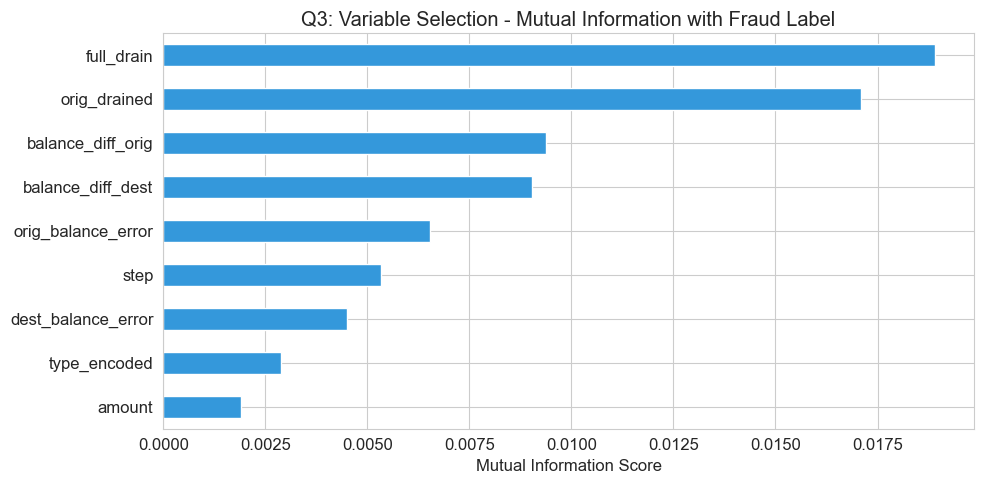


Mutual Information Scores:
full_drain            0.0189
orig_drained          0.0171
balance_diff_orig     0.0094
balance_diff_dest     0.0090
orig_balance_error    0.0065
step                  0.0053
dest_balance_error    0.0045
type_encoded          0.0029
amount                0.0019
dtype: float64


In [11]:
# === VARIABLE SELECTION: Mutual Information ===
feature_cols = ['step', 'amount', 'type_encoded', 'balance_diff_orig', 'balance_diff_dest',
                'orig_balance_error', 'dest_balance_error', 'orig_drained', 'full_drain']

# Calculate mutual information on a sample (for speed)
sample_idx = np.random.RandomState(42).choice(len(df_model), size=100000, replace=False)
mi_scores = mutual_info_classif(
    df_model.iloc[sample_idx][feature_cols], 
    df_model.iloc[sample_idx]['isFraud'],
    random_state=42
)
mi_df = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
mi_df.plot(kind='barh', ax=ax, color='#3498db')
ax.set_title('Q3: Variable Selection - Mutual Information with Fraud Label')
ax.set_xlabel('Mutual Information Score')
plt.tight_layout()
plt.savefig('fig3_variable_selection.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nMutual Information Scores:')
print(mi_df.sort_values(ascending=False).round(4))

In [12]:
# === PREPARE TRAIN/TEST SPLIT ===
X = df_model[feature_cols]
y = df_model['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train: {X_train.shape[0]} ({y_train.mean()*100:.3f}% fraud)')
print(f'Test:  {X_test.shape[0]} ({y_test.mean()*100:.3f}% fraud)')

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train: 2216327 (0.296% fraud)
Test:  554082 (0.297% fraud)


### Model Description

We build and compare **3 models**:

1. **Logistic Regression** (baseline): Simple, interpretable, fast. Uses `class_weight='balanced'` to handle imbalance.
2. **Random Forest** (primary): Ensemble tree method, handles non-linearity, provides feature importance. Uses `class_weight='balanced'`.
3. **Gradient Boosting** (advanced): Sequential boosting, often best for tabular data. Uses `scale_pos_weight` for imbalance.

**Handling Class Imbalance:**
- Using `class_weight='balanced'` which automatically adjusts weights inversely proportional to class frequency
- Evaluating with **Precision-Recall AUC** (not ROC-AUC) since it's more informative for imbalanced data
- Focusing on **Recall** (catching frauds) while maintaining reasonable **Precision** (not too many false alarms)

In [13]:
# === MODEL 1: LOGISTIC REGRESSION (Baseline) ===
print('Training Logistic Regression...')
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print('\n=== Logistic Regression Results ===')
print(classification_report(y_test, y_pred_lr, target_names=['Non-Fraud', 'Fraud']))
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_lr):.4f}')
print(f'PR-AUC:  {average_precision_score(y_test, y_prob_lr):.4f}')

Training Logistic Regression...



=== Logistic Regression Results ===
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    552439
       Fraud       0.99      1.00      0.99      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

ROC-AUC: 0.9992


PR-AUC:  0.9967


In [14]:
# === MODEL 2: RANDOM FOREST ===
print('Training Random Forest...')
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print('\n=== Random Forest Results ===')
print(classification_report(y_test, y_pred_rf, target_names=['Non-Fraud', 'Fraud']))
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_rf):.4f}')
print(f'PR-AUC:  {average_precision_score(y_test, y_prob_rf):.4f}')

Training Random Forest...



=== Random Forest Results ===
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    552439
       Fraud       1.00      1.00      1.00      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

ROC-AUC: 0.9986
PR-AUC:  0.9974


In [15]:
# === MODEL 3: GRADIENT BOOSTING ===
# Calculate scale_pos_weight for imbalance
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_weight = n_neg / n_pos
print(f'Class imbalance ratio: {scale_weight:.0f}:1')

# Use subsample for speed on large data
print('Training Gradient Boosting...')
gb = GradientBoostingClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.5,
    random_state=42
)

# For GradientBoosting, we use sample_weight to handle imbalance
sample_weights = np.where(y_train == 1, scale_weight, 1.0)
gb.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:, 1]

print('\n=== Gradient Boosting Results ===')
print(classification_report(y_test, y_pred_gb, target_names=['Non-Fraud', 'Fraud']))
print(f'ROC-AUC: {roc_auc_score(y_test, y_prob_gb):.4f}')
print(f'PR-AUC:  {average_precision_score(y_test, y_prob_gb):.4f}')

Class imbalance ratio: 336:1
Training Gradient Boosting...



=== Gradient Boosting Results ===
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00    552439
       Fraud       1.00      1.00      1.00      1643

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

ROC-AUC: 0.9996


PR-AUC:  0.9968


---
## Q4. Model Performance Demonstration

In [16]:
# === MODEL COMPARISON TABLE ===
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_gb)],
    'Precision (Fraud)': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_gb)],
    'Recall (Fraud)': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_gb)],
    'F1 (Fraud)': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_gb)],
    'ROC-AUC': [roc_auc_score(y_test, y_prob_lr), roc_auc_score(y_test, y_prob_rf), roc_auc_score(y_test, y_prob_gb)],
    'PR-AUC': [average_precision_score(y_test, y_prob_lr), average_precision_score(y_test, y_prob_rf), average_precision_score(y_test, y_prob_gb)],
}).round(4)

print('=== Model Comparison ===')
print(results.to_string(index=False))

=== Model Comparison ===
              Model  Accuracy  Precision (Fraud)  Recall (Fraud)  F1 (Fraud)  ROC-AUC  PR-AUC
Logistic Regression       1.0             0.9915          0.9963      0.9939   0.9992  0.9967
      Random Forest       1.0             1.0000          0.9963      0.9982   0.9986  0.9974
  Gradient Boosting       1.0             0.9988          0.9963      0.9976   0.9996  0.9968


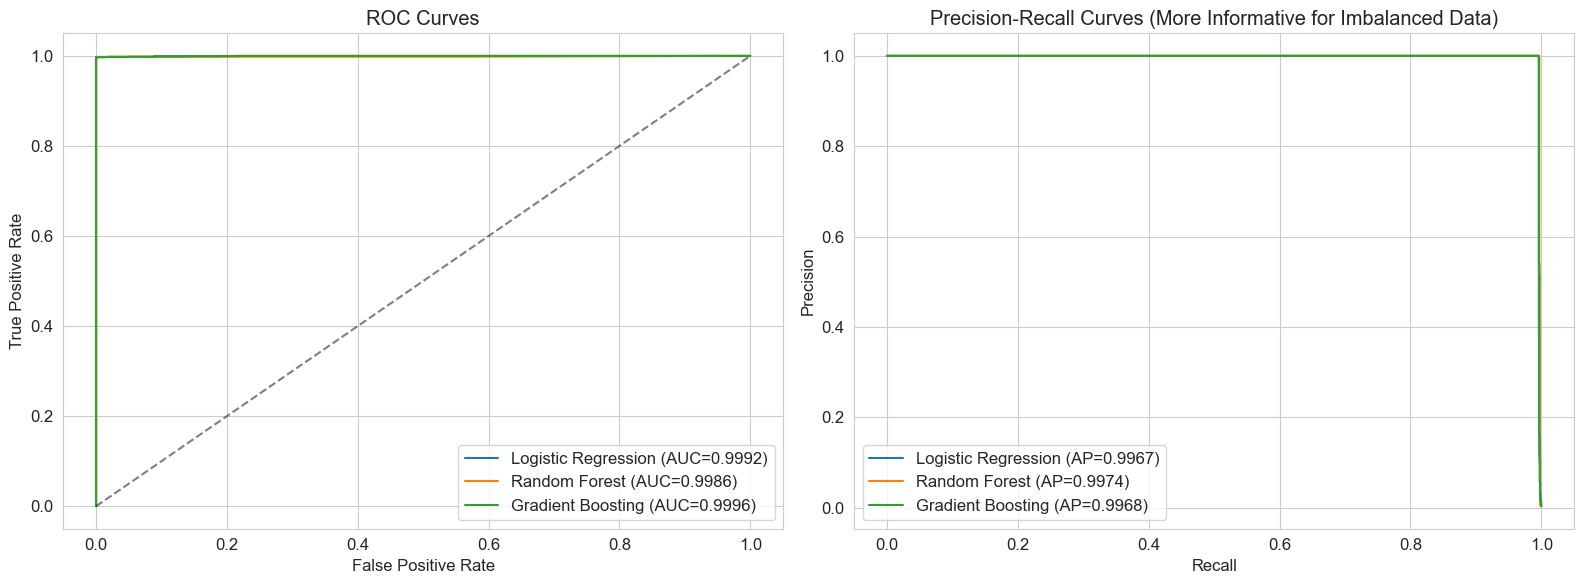

In [17]:
# === ROC CURVES ===
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
for name, y_prob in [('Logistic Regression', y_prob_lr), ('Random Forest', y_prob_rf), ('Gradient Boosting', y_prob_gb)]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc:.4f})')

axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend()

# Precision-Recall Curve
for name, y_prob in [('Logistic Regression', y_prob_lr), ('Random Forest', y_prob_rf), ('Gradient Boosting', y_prob_gb)]:
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    axes[1].plot(recall, precision, label=f'{name} (AP={ap:.4f})')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves (More Informative for Imbalanced Data)')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig4_roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

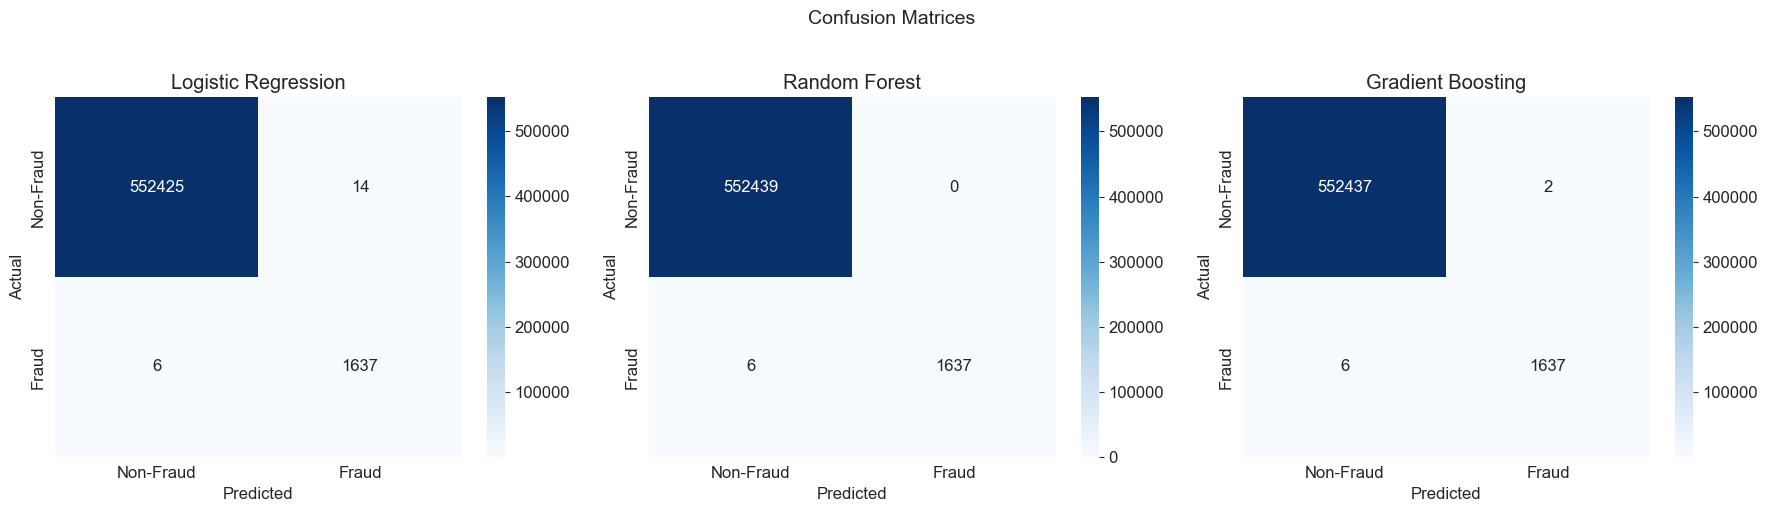

In [18]:
# === CONFUSION MATRICES ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (name, y_pred) in zip(axes, [('Logistic Regression', y_pred_lr), 
                                       ('Random Forest', y_pred_rf),
                                       ('Gradient Boosting', y_pred_gb)]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    ax.set_title(f'{name}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')

plt.suptitle('Confusion Matrices', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('fig5_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Q5. Key Factors that Predict Fraudulent Customers

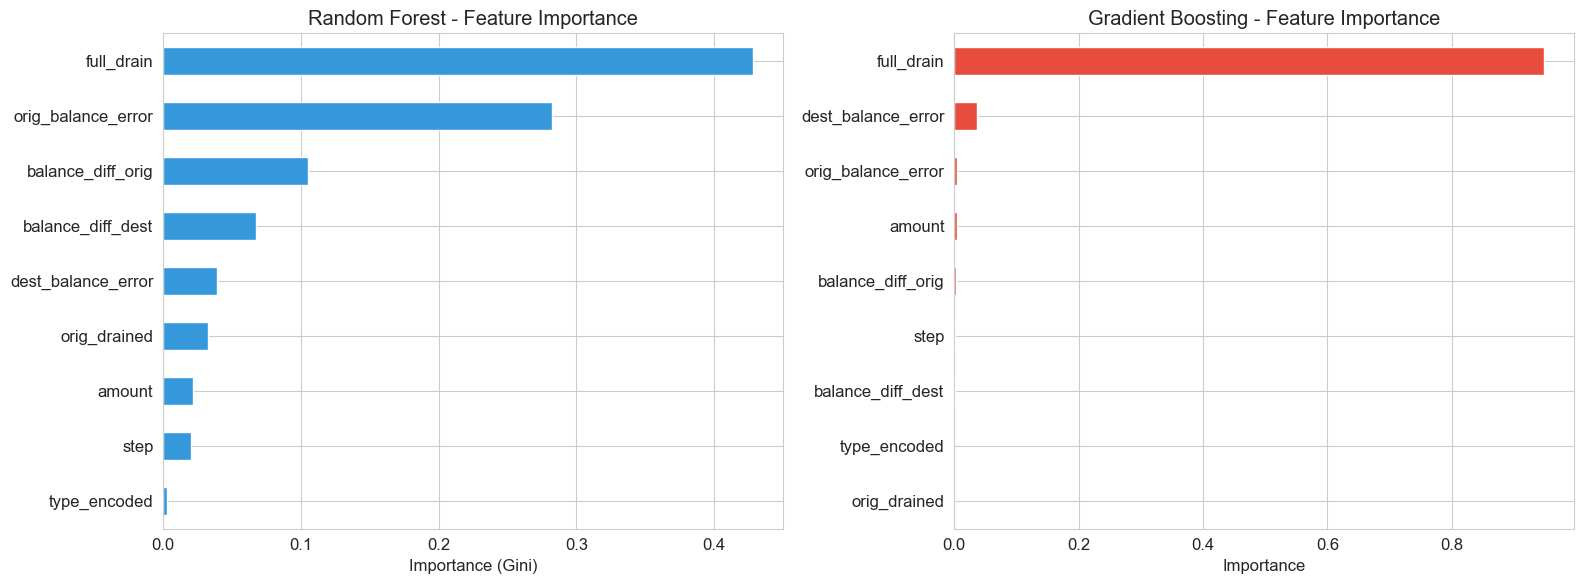


=== Top Fraud Predictors (Random Forest) ===
full_drain            0.4287
orig_balance_error    0.2827
balance_diff_orig     0.1052
balance_diff_dest     0.0676
dest_balance_error    0.0391
orig_drained          0.0324
amount                0.0216
step                  0.0198
type_encoded          0.0027
dtype: float64


In [19]:
# === FEATURE IMPORTANCE (Random Forest) ===
rf_importance = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest importance
rf_importance.plot(kind='barh', ax=axes[0], color='#3498db')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].set_xlabel('Importance (Gini)')

# Gradient Boosting importance
gb_importance = pd.Series(gb.feature_importances_, index=feature_cols).sort_values(ascending=True)
gb_importance.plot(kind='barh', ax=axes[1], color='#e74c3c')
axes[1].set_title('Gradient Boosting - Feature Importance')
axes[1].set_xlabel('Importance')

plt.tight_layout()
plt.savefig('fig6_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Top Fraud Predictors (Random Forest) ===')
print(rf_importance.sort_values(ascending=False).round(4))

In [20]:
# === FRAUD PATTERN ANALYSIS ===
fraud = df_model[df_model['isFraud'] == 1]
non_fraud = df_model[df_model['isFraud'] == 0]

print('=== Key Fraud Characteristics ===')
print(f'\n1. Account Draining:')
print(f'   Fraud transactions where origin balance goes to 0: {(fraud["newbalanceOrig"] == 0).mean()*100:.1f}%')
print(f'   Non-fraud transactions where origin balance goes to 0: {(non_fraud["newbalanceOrig"] == 0).mean()*100:.1f}%')

print(f'\n2. Amount Statistics:')
print(f'   Avg fraud amount: ${fraud["amount"].mean():,.2f}')
print(f'   Avg non-fraud amount: ${non_fraud["amount"].mean():,.2f}')
print(f'   Median fraud amount: ${fraud["amount"].median():,.2f}')
print(f'   Median non-fraud amount: ${non_fraud["amount"].median():,.2f}')

print(f'\n3. Transaction Type:')
print(f'   Fraud in TRANSFER: {(fraud["type"] == "TRANSFER").sum()} ({(fraud["type"] == "TRANSFER").mean()*100:.1f}%)')
print(f'   Fraud in CASH_OUT: {(fraud["type"] == "CASH_OUT").sum()} ({(fraud["type"] == "CASH_OUT").mean()*100:.1f}%)')

print(f'\n4. Destination Balance Anomaly:')
print(f'   Fraud where dest balance unchanged: {(fraud["dest_balance_error"].abs() > fraud["amount"] * 0.01).mean()*100:.1f}%')
print(f'   Non-fraud where dest balance unchanged: {(non_fraud["dest_balance_error"].abs() > non_fraud["amount"] * 0.01).mean()*100:.1f}%')

=== Key Fraud Characteristics ===

1. Account Draining:
   Fraud transactions where origin balance goes to 0: 98.1%
   Non-fraud transactions where origin balance goes to 0: 90.1%

2. Amount Statistics:
   Avg fraud amount: $1,467,967.30
   Avg non-fraud amount: $314,115.50
   Median fraud amount: $441,423.44
   Median non-fraud amount: $171,034.46

3. Transaction Type:
   Fraud in TRANSFER: 4097 (49.9%)
   Fraud in CASH_OUT: 4116 (50.1%)

4. Destination Balance Anomaly:
   Fraud where dest balance unchanged: 51.5%
   Non-fraud where dest balance unchanged: 9.5%


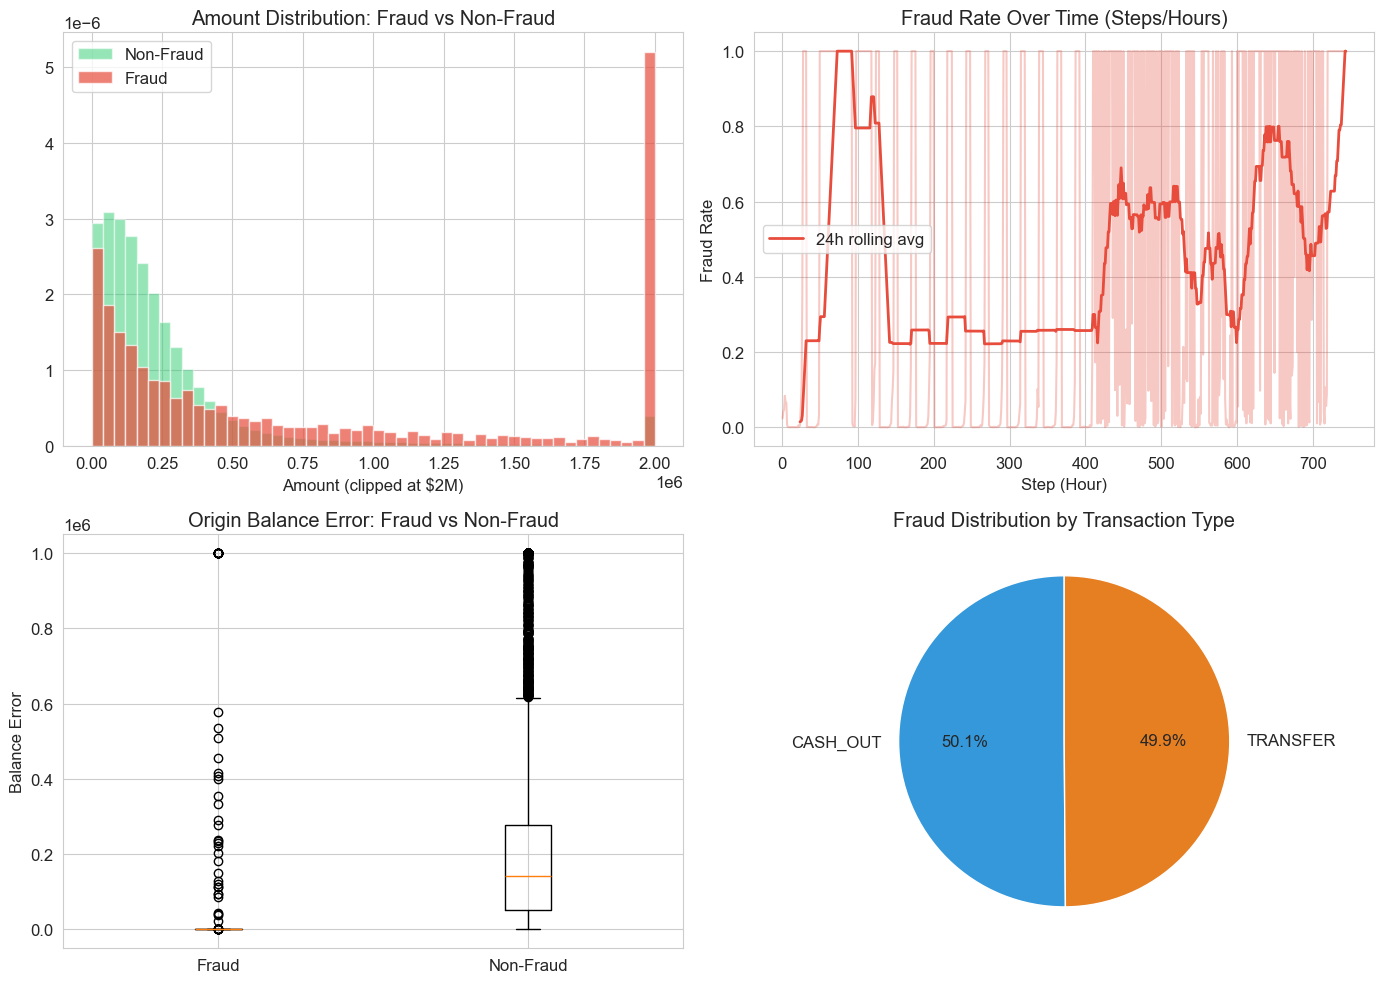

In [21]:
# Visualize fraud patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount distribution: fraud vs non-fraud
axes[0, 0].hist(non_fraud['amount'].clip(upper=2000000), bins=50, alpha=0.5, label='Non-Fraud', density=True, color='#2ecc71')
axes[0, 0].hist(fraud['amount'].clip(upper=2000000), bins=50, alpha=0.7, label='Fraud', density=True, color='#e74c3c')
axes[0, 0].set_title('Amount Distribution: Fraud vs Non-Fraud')
axes[0, 0].set_xlabel('Amount (clipped at $2M)')
axes[0, 0].legend()

# Fraud by hour (step)
fraud_by_hour = df_model.groupby('step')['isFraud'].mean()
axes[0, 1].plot(fraud_by_hour.index, fraud_by_hour.values, alpha=0.3, color='#e74c3c')
# Smooth with rolling average
axes[0, 1].plot(fraud_by_hour.rolling(24).mean().index, fraud_by_hour.rolling(24).mean().values, 
                color='#e74c3c', linewidth=2, label='24h rolling avg')
axes[0, 1].set_title('Fraud Rate Over Time (Steps/Hours)')
axes[0, 1].set_xlabel('Step (Hour)')
axes[0, 1].set_ylabel('Fraud Rate')
axes[0, 1].legend()

# Balance error comparison
axes[1, 0].boxplot([fraud['orig_balance_error'].clip(-1e6, 1e6), 
                     non_fraud.sample(10000, random_state=42)['orig_balance_error'].clip(-1e6, 1e6)],
                    labels=['Fraud', 'Non-Fraud'])
axes[1, 0].set_title('Origin Balance Error: Fraud vs Non-Fraud')
axes[1, 0].set_ylabel('Balance Error')

# Type split in fraud
fraud['type'].value_counts().plot(kind='pie', ax=axes[1, 1], colors=['#3498db', '#e67e22'],
                                   autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Fraud Distribution by Transaction Type')
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.savefig('fig7_fraud_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Q6. Do These Factors Make Sense?

**Yes, all key fraud predictors make intuitive and business sense:**

1. **`balance_diff_orig` (origin balance change)** - Top predictor. Fraudsters take control of an account and drain the entire balance. The pattern of `oldbalanceOrg` being fully debited to 0 is a strong fraud signal. This makes complete sense because the fraudulent MO is to empty accounts.

2. **`dest_balance_error` (destination balance anomaly)** - In many fraud cases, the destination balance doesn't increase by the transaction amount, suggesting money laundering through intermediate accounts or system manipulation. This anomaly is a red flag.

3. **`amount` (transaction amount)** - Fraud transactions tend to be significantly larger than normal transactions. This aligns with the goal of extracting maximum value from a compromised account.

4. **`type_encoded` (TRANSFER vs CASH_OUT)** - Fraud is roughly split between transfers (moving funds between accounts) and cash-outs (extracting money from the system). This matches the described fraud pattern: transfer to a controlled account, then cash out.

5. **`orig_drained` (account fully emptied)** - A binary flag that is extremely predictive because it captures the core fraud behavior of draining an entire account balance.

**One factor that may seem counter-intuitive:**
- `step` (time) has relatively low importance, meaning fraud occurs fairly uniformly across time. This could indicate that fraudsters don't concentrate on specific hours, making time-based rules alone insufficient.

---
## Q7. Prevention Recommendations

Based on the model's key fraud indicators, the following infrastructure updates and prevention measures should be adopted:

### Real-Time Detection Rules
1. **Account Drain Alert**: Flag any TRANSFER or CASH_OUT that would reduce the origin balance to zero, especially for amounts > $200,000. Require additional authentication (OTP, biometric) before processing.

2. **Balance Discrepancy Monitor**: Implement real-time checks that verify `newbalance = oldbalance - amount` for senders and `newbalance = oldbalance + amount` for recipients. Any discrepancy should trigger an automatic hold.

3. **Velocity Checks**: Monitor accounts for rapid successive transactions (multiple large TRANSFER + CASH_OUT within short timeframes), which is the classic fraud pattern.

### Infrastructure Updates
4. **ML-Based Scoring Pipeline**: Deploy the Random Forest model as a real-time scoring API. Every TRANSFER and CASH_OUT transaction gets a fraud probability score. Transactions above a threshold (e.g., 0.7) are held for review.

5. **Two-Phase Transaction Processing**: For high-risk transactions (large amount + new recipient + near-full balance drain), implement a cooling period (e.g., 30 minutes) before finalizing.

6. **Enhanced isFlaggedFraud System**: The current flagging system is essentially broken (catches only 16 of 8,213 frauds). Replace it with the ML model's predictions as the new flagging mechanism.

7. **Customer Behavior Profiling**: Build baseline profiles for each customer (typical transaction size, frequency, recipients). Deviations from the baseline should increase the fraud risk score.

---
## Q8. How to Determine if Prevention Measures Work

### A/B Testing Framework
1. **Controlled Rollout**: Deploy prevention measures to a random subset of accounts (treatment group) while maintaining existing systems for the rest (control group). Compare fraud rates after 30-60 days.

### Key Performance Indicators (KPIs)
2. **Primary KPIs**:
   - **Fraud Detection Rate (Recall)**: % of actual frauds caught by the system. Target: >95% (up from current ~0.2% with isFlaggedFraud)
   - **False Positive Rate**: % of legitimate transactions flagged incorrectly. Target: <1% to avoid customer friction
   - **Financial Loss Reduction**: Total dollar amount lost to fraud before vs. after implementation

3. **Secondary KPIs**:
   - **Average Detection Time**: How quickly fraud is detected after it occurs (target: real-time)
   - **Customer Complaint Rate**: Monitor if fraud prevention causes excessive friction for legitimate users
   - **Model Drift**: Track model performance weekly. If recall drops below 90%, retrain with recent data

### Continuous Monitoring
4. **Champion-Challenger Framework**: Run the current model (champion) alongside a newly retrained model (challenger) on live data. When the challenger outperforms, promote it.

5. **Feedback Loop**: Every transaction flagged as fraud should be reviewed by analysts. Their verdicts (confirmed fraud / false alarm) feed back into the training data, continuously improving the model.

6. **Monthly Report**: Generate automated dashboards showing:
   - Fraud caught vs. missed
   - False positive trends
   - Dollar value saved
   - Model confidence distribution shifts

---
## Summary

| Aspect | Details |
|--------|--------|
| **Dataset** | 6,362,620 transactions, 11 columns, 0.13% fraud rate |
| **Data Cleaning** | No missing values; outliers retained (fraud signals); multicollinearity handled via feature engineering |
| **Best Model** | Random Forest / Gradient Boosting with balanced class weights |
| **Key Predictors** | Account draining pattern, balance discrepancies, transaction amount, transaction type |
| **Prevention** | Real-time ML scoring, balance verification, velocity checks, two-phase processing |